# Textbook Quantum Phase Estimation

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `TextbookQPE`
Phase Estimation algorithm as presented in Chapter 5.2 of Neilson & Chuang

The bloq implements the following phase estimation circuit, where `ctrl_state_prep` and
`qft_inv` are configurable parameters.

```
       ┌─────────┐                              ┌─────────┐
  |0> -│         │-----------------------@------│         │---M--- [m1]:highest bit
       │         │                       |      │         │
  |0> -│         │-----------------@-----+------│         │---M--- [m2]
       │CtrlState│                 |     |      │ QFT_inv │
  |0> -│  Prep   │-----------@-----+-----+------│         │---M--- [m3]
       │         │           |     |     |      │         │
  |0> -│         │-----@-----+-----+-----+------│         │---M--- [m4]:lowest bit
       └─────────┘     |     |     |     |      └─────────┘
|Psi> -----------------U-----U^2---U^4---U^8---------------------- |Psi>
```

Note that the circuit measures $\varphi$ (in fixed point representation,
so $0 \leq \varphi \leq 1$) s.t. $e^{i\phi}$ is an eigenvalue of $U$ where $\phi = 2\pi\varphi$
is the estimated phase.

The standard textbook version, as described in Ref[1], uses

1. A uniform state preparation via hadamard on all control qubits for `CtrlStatePrep`
2. A textbook QFT inverse algorithm, implemented in `QFTTextBook`, for `QFT_inv`

Some useful properties of the phase estimation algorithm are given as follows -

## Cost of TextbookQPE
The cost of textbook QPE on `m` control qubits is a sum of costs of

1. **CtrlStatePrep** - This typically scales as $\mathcal{O}(m)$. For uniform state preparation,
        the cost is simply $m$ clifford gates.
2. **Controlled-Us** - There are two cases:
    1. If the unitary is fast forwardable; i.e. cost of $U^n$ is independent of $n$, the cost
        of this step is simply $\mathcal{O}(m \text{ cost(C-U)})$
    2. If the unitary is not fast forwardable; the cost of this step is
        $\mathcal{O}((2 ^ {m} - 1) \text{cost(C-U)})$.
4. **QFT_inv** - The textbook version of QFT uses $\mathcal{O}(m^2)$ rotations but this can be
        improved to $\mathcal{O}(m \log{m})$ using approximate QFT constructions.

As seen above, in most cases the dominant cost of phase estimation comes from step 2.B, which
depends exponentially on the number of control bits $m$.

## Choosing number of control bits - $m$.
In the analysis below, we assume the textbook version of phase estimation where `CtrlStatePrep`
is a uniform state preparation. One can obtain smaller values for $m$ when using different
initial states for the control register, like then `LPResourceState` implemented in Qualtran.

### Dependence of $m$ using precision $n$ and success probability $\delta$ as the measure of uncertainty
One way to think about the uncertainty in the obtained phase is to consider the problem where
you wish to estimate the phase $\varphi$ upto $n$ bits of precision (i.e. with accuracy
$2^{-n}$) with probability of success $1 - \delta$. In this setup, the expression of $m$ can be
written as (following Eq 5.35 of Ref[1])

$$
    m = n + \left\lceil\log_2\left({2 + \frac{2}{\delta}}\right)\right\rceil
$$

Setting the number of bits $m$ as per the expression above, we get

$$
    Pr\left[|\tilde{\varphi} - \varphi| < \frac{1}{2^n}\right] \geq 1 - \delta
$$

Here $\varphi$ is the true phase and $\tilde{\varphi}$ is the estimated phase.

`TextbookQPE.from_precision_and_delta` method can be used to instantiate the Bloq with
parameters $m$ and $\delta$ as described above.

### Dependence of $m$ using standard deviation $\epsilon$ as the measure of uncertainty
A stronger way to bound the uncertainty in the obtained phase is to bound the variance of the
estimator $\tilde{\varphi}$ by a given parameter $\epsilon$. Following the analysis in Ref[1,2],
we can show that the variance for textbook phase estimation follows the Standard Quantum
Limit(SQL) of

$$
    \sigma[\phi] = 2\pi \sigma[\tilde{\varphi}] = 2\pi\sqrt{\text{Var}[\tilde{\varphi}]}
                                                \leq\frac{\pi}{\sqrt{M}}=\frac{\pi}{\sqrt{2^m}}
$$

Therefore, to bound the standard deviation of the phase estimator $\tilde{\phi}$ by given parameter
$\epsilon$, we set

$$
    m = \left\lceil2\log_2 \left(\frac{\pi}{\epsilon}\right)\right\rceil
$$

`TextbookQPE.from_standard_deviation_eps` method can be used to instantiate the Bloq with
parameter $\epsilon$ as described above.


#### Parameters
 - `unitary`: Bloq representing the unitary to run the phase estimation protocol on.
 - `m_bits`: Bitsize of the phase register to be used during phase estimation.
 - `ctrl_state_prep`: Bloq to prepare the control state on the phase register. Defaults to `OnEach(self.m_bits, Hadamard())`.
 - `qft_inv`: Bloq to apply inverse QFT on the phase register. Defaults to `QFTTextBook(self.m_bits).adjoint()`  

#### Registers
 - `qpe_reg`: Control register of type `QFxp(self.m_bits, self.m_bits)` for phase estimation.
 - `target registers`: All registers used in `self.unitary.signature`  

#### References
 - [Quantum Computation and Quantum Information: 10th Anniversary Edition, Nielsen & Chuang](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview). Chapter 5.2
 - [Entanglement-free Heisenberg-limited phase estimation](https://arxiv.org/abs/0709.2996). 


In [2]:
from qualtran.bloqs.phase_estimation import TextbookQPE

### Example Instances

In [3]:
from qualtran.bloqs.basic_gates import ZPowGate
from qualtran.bloqs.phase_estimation import TextbookQPE

textbook_qpe_small = TextbookQPE(ZPowGate(exponent=2 * 0.234), 3)

In [4]:
import sympy

from qualtran.bloqs.basic_gates import ZPowGate
from qualtran.bloqs.phase_estimation import TextbookQPE

theta = sympy.Symbol('theta')
m_bits = sympy.Symbol('m')
textbook_qpe_using_m_bits = TextbookQPE(ZPowGate(exponent=2 * theta), m_bits)

In [5]:
import sympy

from qualtran.bloqs.basic_gates import ZPowGate
from qualtran.bloqs.phase_estimation import TextbookQPE

theta = sympy.Symbol('theta')
epsilon = sympy.symbols('epsilon')
textbook_qpe_from_standard_deviation_eps = TextbookQPE.from_standard_deviation_eps(
    ZPowGate(exponent=2 * theta), epsilon
)

In [6]:
import sympy

from qualtran.bloqs.basic_gates import ZPowGate
from qualtran.bloqs.phase_estimation import TextbookQPE

theta = sympy.Symbol('theta')
precision, delta = sympy.symbols('n, delta')
textbook_qpe_from_precision_and_delta = TextbookQPE.from_precision_and_delta(
    ZPowGate(exponent=2 * theta), precision, delta
)

#### Graphical Signature

In [7]:
from qualtran.drawing import show_bloqs
show_bloqs([textbook_qpe_small, textbook_qpe_using_m_bits, textbook_qpe_from_standard_deviation_eps, textbook_qpe_from_precision_and_delta],
           ['`textbook_qpe_small`', '`textbook_qpe_using_m_bits`', '`textbook_qpe_from_standard_deviation_eps`', '`textbook_qpe_from_precision_and_delta`'])

### Call Graph

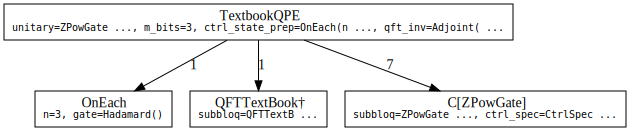

#### Counts totals:
 - `Adjoint(subbloq=QFTTextBook)`: 1
 - `C[Z**0.468]`: 7
 - `H⨂3`: 1

In [8]:
from qualtran.resource_counting.generalizers import ignore_split_join
textbook_qpe_small_g, textbook_qpe_small_sigma = textbook_qpe_small.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(textbook_qpe_small_g)
show_counts_sigma(textbook_qpe_small_sigma)

## Appendix

### Derivation of variance for textbook phase estimation 

When using a phase register of size  $m$ and uniform superposition state as the initial state, textbook phase estimation ends with a state

$$
    \frac{1}{2^m}\sum_{k, l=0}^{2^m-1}e^\frac{-2\pi i k l}{2^m} e^{2 \pi i \varphi k} |l\rangle
$$

Let $b$ be an integer in the range $[0, 2^m)$ that represents the best $m$-bit estimate of the phase $\varphi$ s.t. $\varphi = b / 2^m + \delta$ where $0 \leq \delta \leq 2^{-m}$. 

Let $\alpha_l$ be the amplitude of state $|(b + l) \text{ mod } 2^m\rangle$, then $\alpha_{l}$ can be written as 

$$
    \alpha_l = \frac{1}{2^m} \left( \frac{1 - e^{2\pi i \left(2^m \delta - l\right)}}
                                         {1 - e^{2\pi i \left(\delta - l/2^m \right)}} \right)
$$

For any real $\theta$, $|1 - e^{i \theta}| \leq 2$, so

$$
    |\alpha_l| \leq \frac{2}{2^m | 1 - e^{2\pi i \left(\delta - l/2^m \right)} | }
$$

Whenever $-\pi \leq \theta \leq \pi$, we have $|1 - e^{i \theta}| \geq \frac{2 |\theta|}{\pi}$ and when $−2^{m−1} \lt l \leq 2^{m−1}$ we have $-\pi \leq 2\pi \left(\delta - l/2^m \right) \leq \pi$. Therefore, we have

$$
    |\alpha_l| \leq \frac{1}{2^{m + 1} |\left(\delta - l/2^m \right)| }
$$

Let $\tilde{\varphi}$ be a random variable that represents the estimated phase. We have

$$
\begin{align}
Var[\tilde{\varphi}]&\leq \sum_{l=-2^{m-1} + 1}^{2^{m-1}} |\alpha_l|^2 \left(\frac{b + l}{2^m} - \varphi\right)^2 \\
                    &= \sum_{l=-2^{m-1} + 1}^{2^{m-1}} |\alpha_l|^2 \left(\delta - l/2^m \right)^2 \\ 
                    &= \sum_{l=-2^{m-1} + 1}^{2^{m-1}} \frac{1}{2^{2(m + 1)} |\left(\delta - l/2^m \right)|}\left(\delta - l/2^m \right)^2 \\
                    &= \sum_{l=-2^{m-1} + 1}^{2^{m-1}} \frac{1}{2^{2(m + 1)}} \\
                    &= \frac{2^m}{2^{2(m + 1)}} = \frac{1}{4 2^{m}} = \frac{1}{4 M}\\
\end{align}
$$

Therefore, we get

$$
    \sigma[\tilde{\phi}] = 2\pi\sigma[\tilde{\varphi}] = \frac{\pi}{\sqrt{M}}
$$